# **Get the data from kaggle**

**Dataset:**
Tuberculosis (TB) Chest X-ray Database
https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset

In [1]:
import kagglehub
import shutil
import zipfile
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

100%|██████████| 663M/663M [00:05<00:00, 124MB/s] 

Extracting files...


In [3]:
print("The dataset is stored here:", path)

The dataset is stored here: /root/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3


In [4]:
destination_kaggle = "/content/tb-dataset"

In [5]:
shutil.move(path, destination_kaggle)

'/content/tb-dataset'

In [ ]:
!wget https://data.mendeley.com/public-api/zip/8j2g3csprk/download/2

In [7]:
medeley_dataset = "/content/2"

In [8]:
destination_medeley = "/content/medeley-dataset"

In [9]:
with zipfile.ZipFile(medeley_dataset, 'r') as zip_ref:
        zip_ref.extractall(destination_medeley)

In [10]:
os.makedirs('/content/data/normal', exist_ok=True)
os.makedirs('/content/data/tb', exist_ok=True)

In [11]:
# Path for the images:
kaggle_normal = "/content/tb-dataset/TB_Chest_Radiography_Database/Normal"
kaggle_tb = "/content/tb-dataset/TB_Chest_Radiography_Database/Tuberculosis"
mendeley_tb = "/content/medeley-dataset/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays"
dest_path_normal = "/content/data/normal"
dest_path_tb = "/content/data/tb"

In [12]:
TARGET_SIZE = (224, 224)

In [13]:
from IPython.utils.path import glob
def process_images(source_path, dest_path, prefix):
  files = []
  for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp']:
    files.extend(glob.glob(os.path.join(source_path, ext)))

  print(f"Processing {len(files)} images from {source_path}...")

  for file in tqdm(files):
    img = cv2.imread(file)
    if img is None: continue # Skip corrupt files

    img = cv2.resize(img, TARGET_SIZE)

    # Save with the source name
    name = f"{prefix}_{os.path.basename(file)}"
    cv2.imwrite(os.path.join(dest_path, name), img)

Let's combine those 2 datasets to have a balanced one with ~2800 TB and non-TB images. Also, we need to resize both to standard 224x224 size.

In [14]:
process_images(kaggle_normal,dest_path_normal,'kaggle')

Processing 3500 images from /content/tb-dataset/TB_Chest_Radiography_Database/Normal...


100%|██████████| 3500/3500 [00:36<00:00, 96.11it/s] 


In [15]:
process_images(kaggle_tb,dest_path_tb,'kaggle')

Processing 700 images from /content/tb-dataset/TB_Chest_Radiography_Database/Tuberculosis...


100%|██████████| 700/700 [00:07<00:00, 96.42it/s] 


In [16]:
process_images(mendeley_tb,dest_path_tb,'mendeley')

Processing 2494 images from /content/medeley-dataset/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays...


100%|██████████| 2494/2494 [00:02<00:00, 1191.40it/s]


In [17]:
print(len(os.listdir('/content/data/normal')))
print(len(os.listdir('/content/data/tb')))

3500
3194


To make datasets equal, we delete 306 normal X-ray images.

In [18]:
count_normal = os.listdir('/content/data/normal')
count_tb = os.listdir('/content/data/tb')

if len(count_normal) > len(count_tb):
  random.seed(42)
  files_to_delete = random.sample(count_normal, len(count_normal) - len(count_tb))

  for f in files_to_delete:
        os.remove(os.path.join(dest_path_normal, f))

In [19]:
print(len(os.listdir('/content/data/normal')))
print(len(os.listdir('/content/data/tb')))

3194
3194


# **EDA**

/tmp/ipython-input-1604522405.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Normal', 'Tuberculosis'], y=[len(os.listdir(dest_path_normal)), len(os.listdir(dest_path_tb))], palette='viridis')


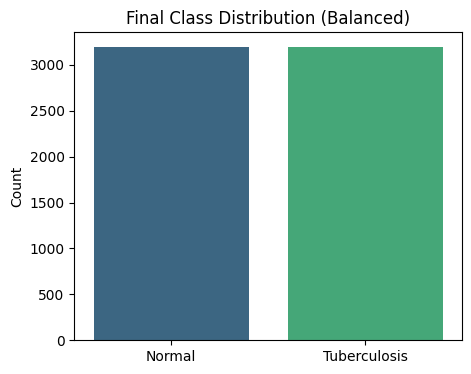

In [20]:
plt.figure(figsize=(5, 4))
sns.barplot(x=['Normal', 'Tuberculosis'], y=[len(os.listdir(dest_path_normal)), len(os.listdir(dest_path_tb))], palette='viridis')
plt.title("Final Class Distribution (Balanced)")
plt.ylabel("Count")
plt.show()

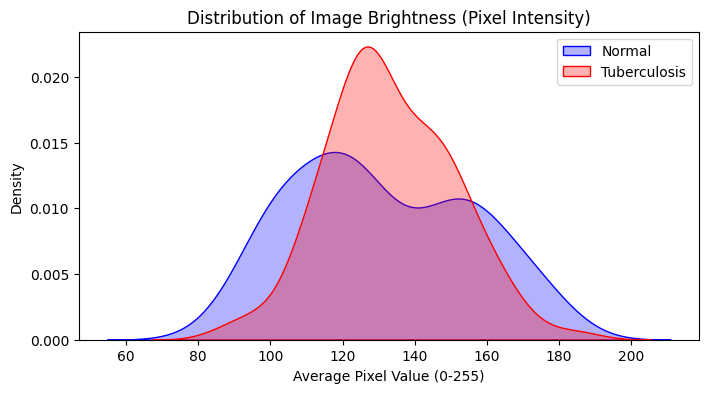

In [21]:
def get_avg_brightness(path, limit=100):
    files = os.listdir(path)[:limit]
    brightness_vals = []
    for f in files:
        img = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness_vals.append(img.mean())
    return brightness_vals

b_normal = get_avg_brightness(dest_path_normal)
b_tb = get_avg_brightness(dest_path_tb)

plt.figure(figsize=(8, 4))
sns.kdeplot(b_normal, label='Normal', fill=True, color='blue', alpha=0.3)
sns.kdeplot(b_tb, label='Tuberculosis', fill=True, color='red', alpha=0.3)
plt.title("Distribution of Image Brightness (Pixel Intensity)")
plt.xlabel("Average Pixel Value (0-255)")
plt.legend()
plt.show()

**Observation:** The Red curve (Tuberculosis) is shifted to the right compared to the Blue curve (Normal). The peak of the TB curve is around pixel intensity 135-140, while the Normal peak is around 115-120.



**Medical Explanation:** X-rays work by density. Air (healthy lungs) appears black (low pixel value ~0). Dense tissue, fluid, and bone appear white (high pixel value ~255).

---

**Conclusion:** Tuberculosis bacteria cause consolidation (fluid/pus filling air sacs), fibrosis (scarring), and calcification in the lungs. These physical changes are denser than air, causing the X-ray to appear "whiter" or "brighter." This explains why the TB distribution has a higher average pixel intensity than the healthy lungs.


**Conclusion 2:** There is still a significant overlap between two curves. That's why simple brightness threshold cannot classify the desease accurately. Person with large ribs might have the same average brightness as a TB patient.
That's why we need a CNN to look for patterns, not just brightenss value.

In [22]:
def plot_grid(n_samples=6):
    # Get random files
    files_norm = random.sample(os.listdir(dest_path_normal), n_samples)
    files_tb = random.sample(os.listdir(dest_path_tb), n_samples)

    # Create a 2 x 6 grid (Top row Normal, Bottom row TB)
    fig, axes = plt.subplots(2, 6, figsize=(16, 6))

    # Plot Normal (Row 0)
    for i, file in enumerate(files_norm):
        img_path = os.path.join(dest_path_normal, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Fix color for matplotlib
        axes[0, i].imshow(img)
        axes[0, i].set_title("Normal")
        axes[0, i].axis('off')

    # Plot TB (Row 1)
    for i, file in enumerate(files_tb):
        img_path = os.path.join(dest_path_tb, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img)
        axes[1, i].set_title("Tuberculosis")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

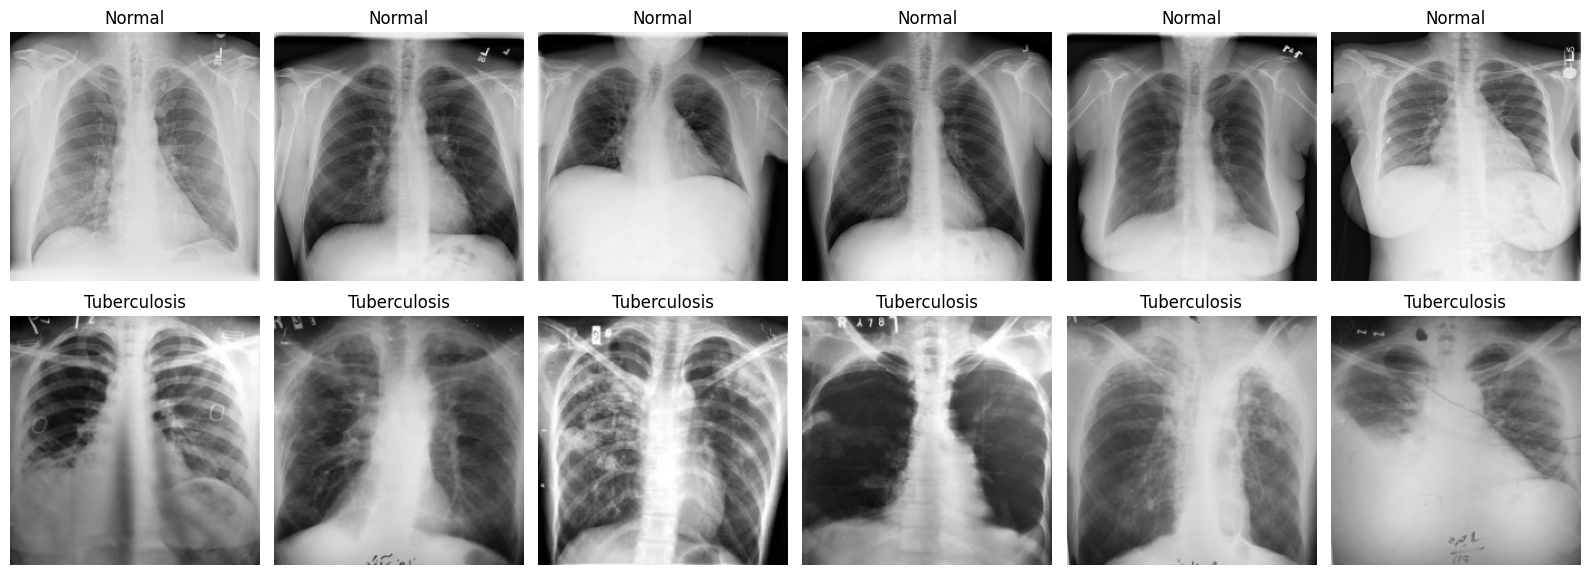

In [23]:
plot_grid(6)

In [24]:
def check_color_mode(path):
    # Read image WITHOUT changing flags (load as-is)
    file = os.listdir(path)[0]
    full_path = os.path.join(path, file)

    # Read using OpenCV default (usually loads as 3-channel BGR)
    img_cv = cv2.imread(full_path)

    # Read using Grayscale flag to compare
    img_gray = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

    print(f"\nAnalysis for folder: {path}")
    print(f"Sample Image: {file}")
    print(f"Shape loaded by default: {img_cv.shape} (Height, Width, Channels)")

    # Check if channels are identical (Fake RGB vs Real RGB)
    if len(img_cv.shape) == 3:
        b, g, r = cv2.split(img_cv)
        if np.array_equal(b, g) and np.array_equal(g, r):
            print("Color Status: Grayscale content (R=G=B).")
            print("Technically saved as 3-channel RGB, but contains only gray info.")
        else:
            print("Color Status: True RGB (Channels differ).")

check_color_mode(dest_path_normal)
check_color_mode(dest_path_tb)


Analysis for folder: /content/data/normal
Sample Image: kaggle_Normal-2698.png
Shape loaded by default: (224, 224, 3) (Height, Width, Channels)
Color Status: Grayscale content (R=G=B).
Technically saved as 3-channel RGB, but contains only gray info.

Analysis for folder: /content/data/tb
Sample Image: mendeley_TB.2497.jpg
Shape loaded by default: (224, 224, 3) (Height, Width, Channels)
Color Status: Grayscale content (R=G=B).
Technically saved as 3-channel RGB, but contains only gray info.


# **Model Training**

***Transfer learning*** consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

***Transfer learning*** is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of ***transfer learning*** in the context of deep learning is the following workflow:



1.   Take layers from a previously trained model.
2.   Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

In [32]:
# To train a CNN we will use Keras and import MobileNetV2

# Imports
import tensorflow as tf

from keras.applications import MobileNetV2
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==================================================================================================================
# Config
DATA_DIR = '/content/data/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ==================================================================================================================
# Load the data
print("Loading Training Data...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds=tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# ==================================================================================================================
# Build the CNN

# Optimization
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Model: we take layers from a previously trained MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, # we don't need a top layer, we replace it with binary classification
    weights='imagenet'
    )

# Freeze
base_model.trainable = False

# Classifier
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Pooling (3D --> 1D)
x = layers.Dropout(0.2)(x) # Regularization

outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# ==================================================================================================================
# Compile and Train
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=8,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max'
    ),

    ReduceLROnPlateau(
      monitor="val_accuracy",
      factor=0.25,
      patience=3,
      min_lr=1e-6,
      verbose=1)
]

# Start the training
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=callbacks
)


Loading Training Data...
Found 6388 files belonging to 2 classes.
Using 5111 files for training.
Found 6388 files belonging to 2 classes.
Using 1277 files for validation.
Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - accuracy: 0.8289 - loss: 0.3807 - recall: 0.8078 - val_accuracy: 0.9107 - val_loss: 0.2310 - val_recall: 0.8241 - learning_rate: 0.0010
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9635 - loss: 0.1207 - recall: 0.9468 - val_accuracy: 0.8896 - val_loss: 0.2821 - val_recall: 0.7824 - learning_rate: 0.0010
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9716 - loss: 0.0866 - recall: 0.9636 - val_accuracy: 0.8700 - val_loss: 0.3563 - val_recall: 0.7438 - learning_rate: 0.0010
Epoch 4/15
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9746 - loss: 0.0724 - recall: 0.9678
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9746 - loss: 0.0

### **Add one more CNN layer**:
This is called creating a "Custom Head.

**Current:** MobileNet $\rightarrow$ Pooling $\rightarrow$ Output

**New:** MobileNet $\rightarrow$ Conv2D $\rightarrow$ Pooling $\rightarrow$ Dense $\rightarrow$ Output.

**Why:** The frozen MobileNet sees generic shapes (lines, circles). Adding a trainable CNN layer allows your model to combine those generic shapes into "TB-specific" features before making a decision.

In [25]:
# To train a CNN we will use Keras and import MobileNetV2

# Imports
import tensorflow as tf

from keras.applications import MobileNetV2
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==================================================================================================================
# Config
DATA_DIR = '/content/data/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ==================================================================================================================
# Load the data
print("Loading Training Data...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds=tf.keras.utils.image_dataset_from_directory(
    directory=DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# ==================================================================================================================
# Build the CNN

# Optimization
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Model: we take layers from a previously trained MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, # we don't need a top layer, we replace it with binary classification
    weights='imagenet'
    )

# Freeze
base_model.trainable = False

# Neural network architecture

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x) # Conv2D layer
x = layers.GlobalAveragePooling2D()(x) # Pooling (3D --> 1D)
x = layers.Dense(64, activation='relu')(x) # Dense layer
x = layers.Dropout(0.5)(x) # Regularization

outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs)

# ==================================================================================================================
# Compile and Train
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=8,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        "model_2.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max'
    ),

    ReduceLROnPlateau(
      monitor="val_accuracy",
      factor=0.25,
      patience=3,
      min_lr=1e-6,
      verbose=1)
]

# Start the training
history = model_2.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=callbacks
)


Loading Training Data...
Found 6388 files belonging to 2 classes.
Using 5111 files for training.
Found 6388 files belonging to 2 classes.
Using 1277 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.8898 - loss: 0.2592 - recall: 0.8799 - val_accuracy: 0.8528 - val_loss: 0.6511 - val_recall: 0.7099 - learning_rate: 0.0010
Epoch 2/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9747 - loss: 0.0770 - recall: 0.9722 - val_accuracy: 0.8512 - val_loss: 0.7974 - val_recall: 0.7068 - learning_rate: 0.0010
Epoch 3/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9838 - loss: 0.0470 - recall: 0.9818 - val_accuracy: 0.8708 - val_loss: 0.6873 - val_recall: 0.7454 - learning_rate: 0.0010
Epoch 4/15
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9873 - loss: 0.0333 - recall: 0.9838 - val_accuracy: 0.8669 - val_loss: 0.7025 - val_recall: 0.7377 - learning_rate: 0.0010
Epoch 5/15
